In [1]:
from ema_workbench.em_framework.optimization import (
    ArchiveLogger, 
    to_problem,
    epsilon_nondominated
)

from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
    Scenario,
    Policy,
    MultiprocessingEvaluator,
)

from ema_workbench.util import ema_logging

import pandas as pd
import numpy as np
from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import seaborn as sns

from set_diversity import find_maxdiverse
import random

from sklearn import preprocessing

from scipy.spatial.distance import pdist, squareform

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
model_a4, planning_steps = get_model_for_problem_formulation('A4 Only')
problem_a4 = to_problem(model_a4, searchover="levers")

# Model with 13 outcomes, neccesary to apply the constraits
model_all, planning_steps = get_model_for_problem_formulation('All Dikes')
problem_all = to_problem(model_all, searchover="levers")

## Read Results

In [4]:
scenarios_df = pd.read_csv('./output/selected_scenarios.csv')
scenarios_df = scenarios_df.set_index('Run ID')
scenarios_df.head()

,A0_ID_flood_wave_shape,A1_Bmax,A1_Brate,A1_pfail,A2_Bmax,A2_Brate,A2_pfail,A3_Bmax,A3_Brate,A3_pfail,A4_Bmax,A4_Brate,A4_pfail,A5_Bmax,A5_Brate,A5_pfail,discount_rate_0,discount_rate_1,discount_rate_2
Run ID,,,,,,,,,,,,,,,,,,,
54840,20,105.319201,10.0,0.372764,290.549630,1.0,0.142059,144.741105,1.0,0.713041,184.297098,10.0,0.029110,83.390052,10.0,0.320759,1.5,1.5,2.5
91325,74,241.014674,1.0,0.427786,141.518951,1.5,0.135387,33.712850,1.0,0.519517,251.142303,1.0,0.010708,50.644440,1.5,0.940807,2.5,1.5,4.5
74784,129,133.550281,1.5,0.933527,252.803332,10.0,0.547453,32.554365,1.0,0.711748,271.783235,10.0,0.090635,207.554354,1.0,0.596976,2.5,4.5,1.5
71789,98,245.492589,1.5,0.730879,103.700541,1.5,0.811144,212.666805,1.5,0.966618,51.327441,10.0,0.044872,285.428060,1.0,0.912670,1.5,1.5,1.5


In [5]:
scenarios = [int(idx) for idx, row in scenarios_df.iterrows()]
scenarios

[54840, 91325, 74784, 71789]

In [6]:
# Assumes seeds are sequential starting at 0 -- could be adapted to arbitrary
results = {}
convergences = {}
archives = {}

for scenario in scenarios:
    results[scenario] = []
    convergences[scenario] = []
    archives[scenario] = []
    for seed in range(5):
        # Results and Convergences
        fn_head = './output/POLICY_SEARCH__'
        fn_tail = f'__scen{scenario}__seed{seed}.csv'

        res = pd.read_csv(fn_head + 'results' + fn_tail, index_col=0)
        results[scenario].append(res)

        conv = pd.read_csv(fn_head + 'convergence' + fn_tail, index_col=0)
        convergences[scenario].append(conv)

        # Archives
        fn_head = './archives/POLICY_SEARCH__'
        fn_tail = f'__scen{scenario}__seed{seed}.tar.gz'
        arch = ArchiveLogger.load_archives(fn_head + 'archive' + fn_tail)
        for key, df in arch.items():
            if 'Unnamed: 0' in df.columns:
                arch[key] = arch[key].drop('Unnamed: 0', axis=1)
        archives[scenario].append(arch)


## Filtering Out Pareto-Dominated Policies
(within each scenario)

In [7]:
policy_sets = {}
epsilon = [100, 0.01, 100, 100, 0.01]
for scenario in scenarios:
    df = epsilon_nondominated(results[scenario], epsilon, problem_a4)
    policy_sets[scenario] = df
    n_policies = df.shape[0]
    print(f"Scenario {scenario} has {n_policies} non-dominated policies")

Scenario 54840 has 116 non-dominated policies
Scenario 91325 has 107 non-dominated policies
Scenario 74784 has 41 non-dominated policies
Scenario 71789 has 22 non-dominated policies


## Test Convergence of Generative Algorithm

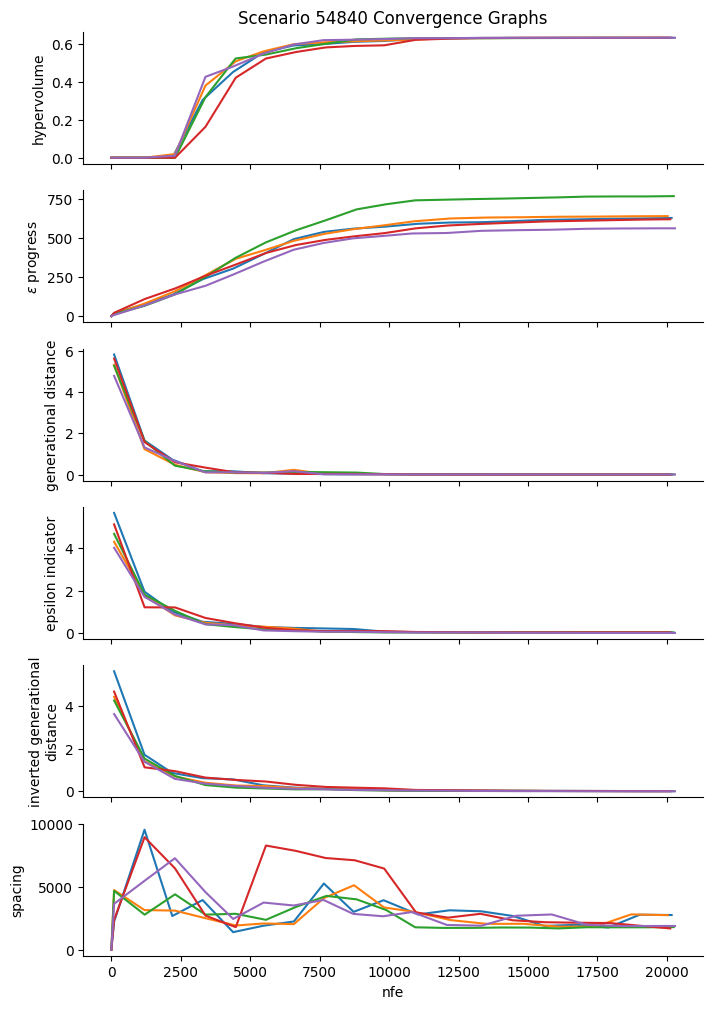

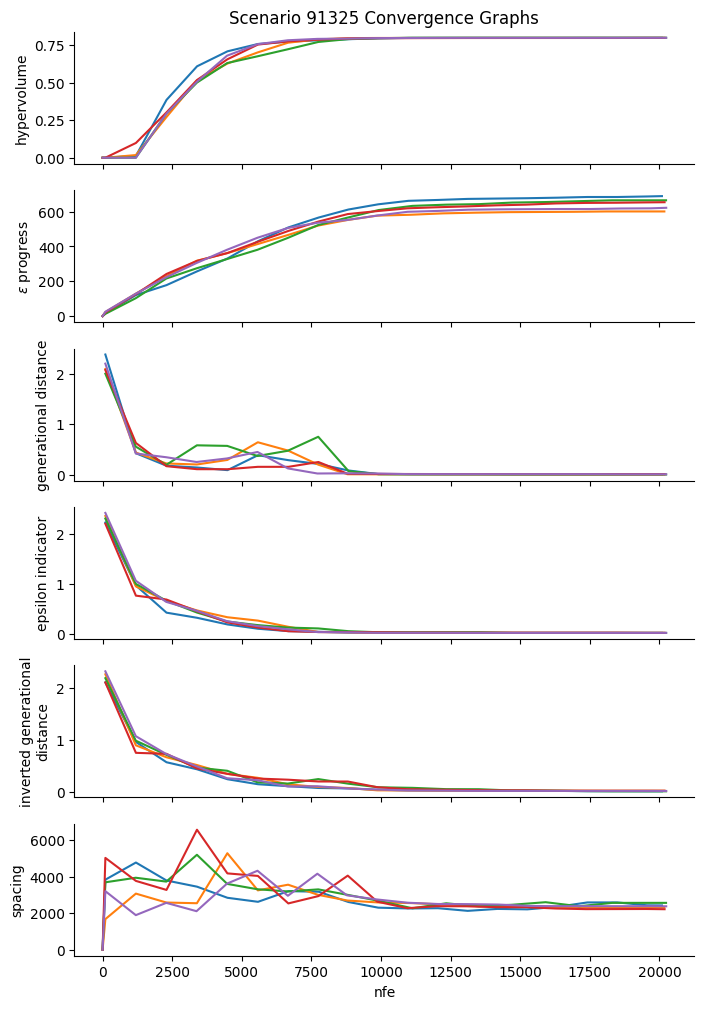

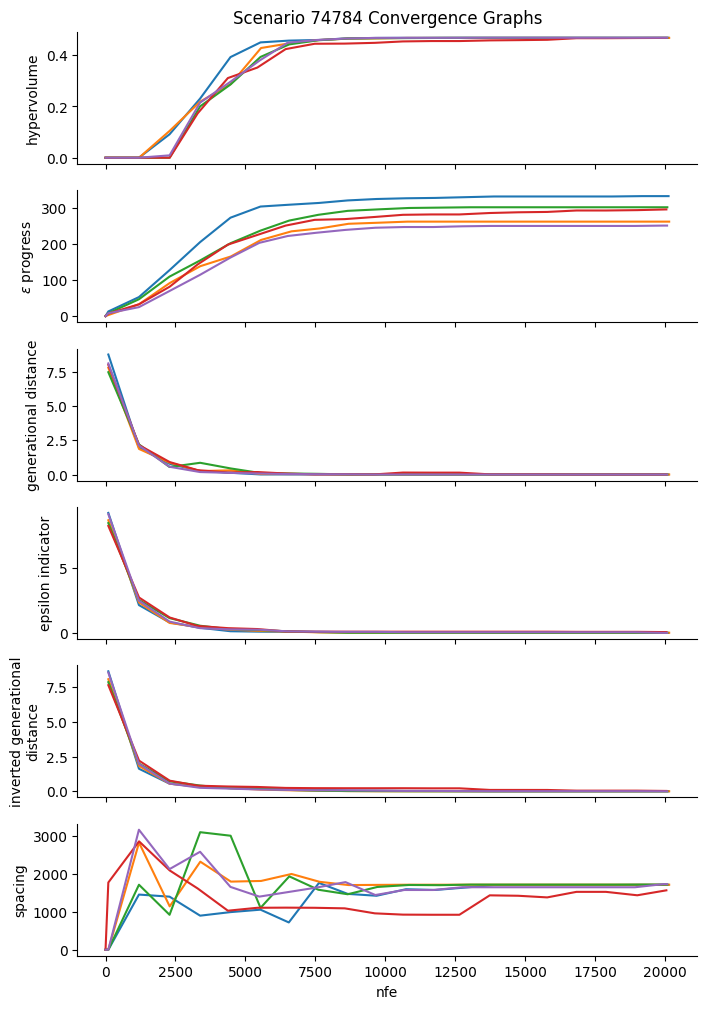

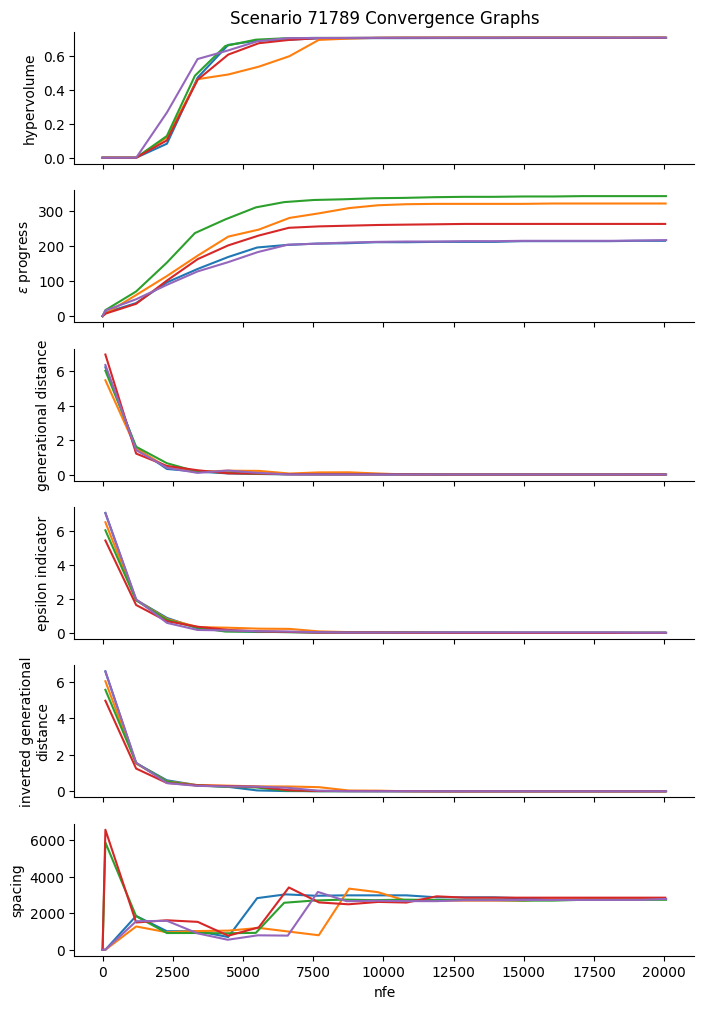

In [8]:
for scenario in scenarios:
    pols = policy_sets[scenario]
    hv = HypervolumeMetric(pols, problem_a4)
    gd = GenerationalDistanceMetric(pols, problem_a4, d=1)
    ei = EpsilonIndicatorMetric(pols, problem_a4)
    ig = InvertedGenerationalDistanceMetric(pols, problem_a4, d=1)
    sm = SpacingMetric(problem_a4)

    metrics_by_seed = []

    for archive in archives[scenario]:
        metrics = []
        for nfe, a in archive.items():
            scores = {
                "generational_distance": gd.calculate(a),
                "hypervolume": hv.calculate(a),
                "epsilon_indicator": ei.calculate(a),
                "inverted_gd": ig.calculate(a),
                "spacing": sm.calculate(a),
                "nfe": int(nfe),
            }
            metrics.append(scores)
        metrics = pd.DataFrame.from_dict(metrics)

        # sort metrics by number of function evaluations
        metrics.sort_values(by="nfe", inplace=True)
        # print(f'{scenario}.{seed} metrics:')
        # print(metrics)
        metrics_by_seed.append(metrics)
    
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    for metrics, convergence in zip(metrics_by_seed, convergences[scenario]):
        ax1.plot(metrics.nfe, metrics.hypervolume)
        ax1.set_ylabel("hypervolume")

        ax2.plot(convergence.nfe, convergence.epsilon_progress)
        ax2.set_ylabel("$\epsilon$ progress")

        ax3.plot(metrics.nfe, metrics.generational_distance)
        ax3.set_ylabel("generational distance")

        ax4.plot(metrics.nfe, metrics.epsilon_indicator)
        ax4.set_ylabel("epsilon indicator")

        ax5.plot(metrics.nfe, metrics.inverted_gd)
        ax5.set_ylabel("inverted generational\ndistance")

        ax6.plot(metrics.nfe, metrics.spacing)
        ax6.set_ylabel("spacing")

    ax6.set_xlabel("nfe")
    ax1.set_title(f'Scenario {scenario} Convergence Graphs')

    sns.despine(fig)
    plt.savefig(f'img/convergence_graphs_scen{scenario}.png')
    plt.show()

----------------------------
## Experimentation: Run Discovered Policies Under Originating Scenario

In [9]:
policies_to_evaluate = {}

for scenario in scenarios:
    policies_to_evaluate[scenario] = []

    policies = policy_sets[scenario]
    for idx, policy in policies.iterrows():
        policy_name = f's{scenario}_p{idx}'
        policies_to_evaluate[scenario].append(Policy(policy_name,
                                              **policy.to_dict()))

    # baseline policy, needed for for relative constraits
    zero_policy = {"EWS_DaysToThreat": 0}
    for i in range(5):
        dike = "A" + str(i+1)
        zero_policy.update({f"{dike}_DikeIncrease_t{n}": 0 for n in planning_steps})
        zero_policy.update({f"rfr_{i}_t{n}": 0 for n in planning_steps})

    p_ref = Policy("Base Case", **zero_policy)
    policies_to_evaluate[scenario].append(p_ref)
    

In [10]:
# Rerun experiment to calculate all outcomes
experiment_results = {}
for scenario in scenarios:
    scenario_dict = {}
    for col in scenarios_df:
        scenario_dict.update({col : scenarios_df.loc[scenario, col]})
    ema_scenario = Scenario(scenario, **scenario_dict)

    with MultiprocessingEvaluator(model_all) as evaluator:
        experiment_results[scenario] = evaluator.perform_experiments(ema_scenario,
                                                    policies_to_evaluate[scenario])

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1 scenarios * 117 policies * 1 model(s) = 117 experiments
100%|████████████████████████████████████████| 117/117 [00:35<00:00,  3.32it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1 scenarios * 108 policies * 1 model(s) = 108 experiments
100%|████████████████████████████████████████| 108/108 [00:34<00:00,  3.13it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1 scenarios * 42 policies * 1 model(s) = 42 experiments
100%|██████████████████████████████████████████| 42/42 [00:13<00:00,  3.00it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1 scenarios * 23 policies * 1 model(s) = 23 experime

In [11]:
# # Plot results of experimentation
# for scenario in scenarios:
#     experiments, outcomes = experiment_results[scenario]
#     outcomes = pd.DataFrame(outcomes)
#     # Drop baseline row
#     data = outcomes
#     limits = parcoords.get_limits(data)
#     limits.loc[0, list(outcomes.columns)] = 0

#     # 30 colors, as sns.color_palette() has less than 18 colors.
#     colors = sns.color_palette("husl", len(outcomes['A4_Expected_Annual_Damage']))
#     paraxes = parcoords.ParallelAxes(limits, fontsize=10)

#     for i, (index, row) in enumerate(data.iterrows()):
#         paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
#     paraxes.legend()

#     plt.show()

------------------
## Apply Constraints

`TODO: change text below `

### relative constraints vs urban: 

"Similar level of protection as people living in the cities"

1. The ratio of **damages** in ring 4 to damages in ring 3 & ring 5 must be at most as the one in the baseline.
2. The ratio of **deaths** in ring 4 to damages in ring 3 & ring 5 must be at most as the one in the baseline.

### relative constraints vs rural:
"your region should have a lower risk of flood than the industrial farmers"

3. The ratio of **damages** in ring 4 to damages in ring 1 & ring 2 must be at most *80%* of the baseline.
4. The ratio of **deaths** in ring 4 to damages in ring 1 & ring 2 must be at most *80%* of the baseline.

**!!!! we can define these constrainst differently (e.g. focus only of deaths or damages, and choose different ratio thresholds. Note, that these are applied only in the reference scenario - if we later run directed search on multiple scenarios of interest (found by PRIM as part of MS-MORDM, we will need to run this notebook for each scenario.**

**Furthermore, we can apply constrains per single outcome at this point as well !!!**

In [12]:
RATIO=1.25 # 1.25 = 1/0.8

In [13]:
satisficing_policies = []
for scenario in scenarios:
    experiments, outcomes = experiment_results[scenario]
    outcomes = pd.DataFrame(outcomes)

    # Calculate ratios
    outcomes['Urban Damages Ratio'] = (outcomes['A4_Expected_Annual_Damage']
                                       / (outcomes['A3_Expected_Annual_Damage']
                                          + outcomes['A5_Expected_Annual_Damage']))

    outcomes['Urban Deaths Ratio'] = (outcomes['A4_Expected_Number_of_Deaths']
                                      / (outcomes['A3_Expected_Number_of_Deaths']
                                         + outcomes['A5_Expected_Number_of_Deaths']))

    outcomes['Industrialized Farmers Damages Ratio'] = (outcomes['A4_Expected_Annual_Damage']
                                                        / (outcomes['A1_Expected_Annual_Damage']
                                                           + outcomes['A2_Expected_Annual_Damage']))

    outcomes['Industrialized Farmers Deaths Ratio'] = (outcomes['A4_Expected_Number_of_Deaths']
                                                       / (outcomes['A1_Expected_Number_of_Deaths']
                                                          + outcomes['A2_Expected_Number_of_Deaths']))
    
    # Determine whether ratios have been exceeded
    base_case = outcomes.iloc[len(outcomes)-1, :]
    outcomes = outcomes.iloc[:len(outcomes)-1, :]

    outcomes['Urban Damages Ratio Exceeded'] = \
            np.where(outcomes['Urban Damages Ratio']
                     > base_case['Urban Damages Ratio'],
                     True,
                     False)
    outcomes['Urban Deaths Ratio Exceeded'] = \
            np.where(outcomes['Urban Deaths Ratio']
                     > base_case['Urban Deaths Ratio'],
                     True,
                     False)

    outcomes['Industrialized Farmers Damages Ratio Exceeded'] = \
            np.where(outcomes['Industrialized Farmers Damages Ratio']
                     > RATIO*base_case['Industrialized Farmers Damages Ratio'],
                     True,
                     False)
    outcomes['Industrialized Farmers Deaths Ratio Exceeded'] = \
            np.where(outcomes['Industrialized Farmers Deaths Ratio']
                     > RATIO*base_case['Industrialized Farmers Deaths Ratio'],
                     True,
                     False)
    
    # Keep rows that satisfy all constraints (all False)
    constraint_cols = [
        'Urban Damages Ratio Exceeded',
        'Urban Deaths Ratio Exceeded',
        'Industrialized Farmers Damages Ratio Exceeded',
        'Industrialized Farmers Deaths Ratio Exceeded'
        ]
    satisficing_policy_outcomes = outcomes[outcomes[constraint_cols].sum(axis=1) == 0]

    for idx, _ in satisficing_policy_outcomes.iterrows():
        satisficing_policies.append(policies_to_evaluate[scenario][idx])

In [14]:
columns = ['Policy Name'] + [key for key in satisficing_policies[0]]
policies_df = pd.DataFrame(columns=columns)

for i, policy in enumerate(satisficing_policies):
    row = []
    for col in columns:
        if col == 'Policy Name':
            row.append(policy.name)
        else:
            row.append(policy[col])
    policies_df.loc[i] = row

In [15]:
print(f'{policies_df.shape[0]} policies satisfy the constraints.')
policies_df.head()

162 policies satisfy the constraints.


,Policy Name,EWS_DaysToThreat,rfr_0_t0,rfr_0_t1,rfr_0_t2,rfr_1_t0,rfr_1_t1,rfr_1_t2,rfr_2_t0,rfr_2_t1,...,A4_DikeIncrease_t1,A4_DikeIncrease_t2,A5_DikeIncrease_t0,A5_DikeIncrease_t1,A5_DikeIncrease_t2,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths
0,s54840_p1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.411318e+06,0.000361,5.198670e+07,7.903696e+08,0.067203
1,s54840_p2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,0.0,0.0,0.000000e+00,0.000000,1.982227e+08,0.000000e+00,0.000000
2,s54840_p4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.000000e+00,0.000000,1.522734e+08,9.001760e+07,0.008647
3,s54840_p6,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.000000e+00,0.000000,1.227336e+08,1.886900e+08,0.017611
4,s54840_p9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.000000e+00,0.000000,1.319741e+08,1.098930e+08,0.012143


In [16]:
policies_df.to_csv('./output/policies__constraints_filtered.csv', index=False)

--------------------------

## Filter for a Diverse Set of Policies


In [17]:
policies_df = pd.read_csv('./output/policies__constraints_filtered.csv')

In [18]:
n_pols = policies_df.shape[0]
indices = []
for idx, row in policies_df.iterrows():
    indices.append(idx)

# Randomly generate sets
random.seed(1361)

combinations = []
for _ in range(100000):
    c = random.sample(indices, 50)
    combinations.append(tuple(c))

In [19]:
policies_levers = policies_df[[l.name for l in model_a4.levers]]
min_max_scaler = preprocessing.MinMaxScaler()
levers_scaled = min_max_scaler.fit_transform(policies_levers)

In [20]:
distances = squareform(pdist(levers_scaled))
policy_set_diversities = find_maxdiverse(distances, combinations)

In [21]:
policy_set_diversities.sort(key=lambda entry:entry[0], reverse=True)

In [22]:
most_diverse = policy_set_diversities[0]
most_diverse_set = list(most_diverse[1])
print(most_diverse_set)

[152, 80, 116, 149, 88, 23, 58, 90, 126, 96, 119, 70, 127, 54, 33, 19, 146, 129, 101, 94, 132, 108, 107, 36, 43, 109, 84, 103, 72, 57, 38, 159, 45, 87, 53, 44, 115, 118, 134, 76, 3, 75, 63, 117, 106, 150, 40, 50, 99, 46]


In [23]:
diverse_policies = policies_df.iloc[most_diverse_set]
assert(diverse_policies.shape[0] == 50)
diverse_policies.head(3)

,Policy Name,EWS_DaysToThreat,rfr_0_t0,rfr_0_t1,rfr_0_t2,rfr_1_t0,rfr_1_t1,rfr_1_t2,rfr_2_t0,rfr_2_t1,...,A4_DikeIncrease_t1,A4_DikeIncrease_t2,A5_DikeIncrease_t0,A5_DikeIncrease_t1,A5_DikeIncrease_t2,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths
152,s71789_p9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.873816e+08,0.007513,6.320800e+06,2.263776e+08,0.011070
80,s91325_p36,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.025814e+08,0.004843,8.453408e+06,1.444547e+09,0.125858
116,s91325_p94,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.000000e+00,0.000000,4.347679e+08,0.000000e+00,0.000000


In [24]:
diverse_policies.to_csv('./output/policies__constraints_filtered__diverse_set_50.csv', index=False)

### Selection of Most Robust Policies

In [25]:
# PREVIOUSLY, THIS CELL WAS USED TO DO PARETO FILTERING ON THE 'MAX REGRET' SCORES.
# IT IS NOT SEPARATED PER-SCENARIO

# # Prepare df for pareto rows selection
# max_regret['Policy Name'] = max_regret.index
# # Selection of policies on the pareto front for max regret
# nondominated_max_regret = pareto.eps_sort([list(max_regret.itertuples(False))], objectives=outcome_columns, epsilons=outcome_epsilons)
# nondominated_max_regret_df = pd.DataFrame(columns=list(max_regret.columns))

# for row in nondominated_max_regret:
#     nondominated_max_regret_df.loc[len(nondominated_max_regret_df)] = row

# nondominated_max_regret_df.head()

In [26]:
# # calculate mean scores df
# overall_scores = {}
# for policy in robust_policy_names:
#     scores = {}
    
#     logical = experiments['policy']==policy
    
#     for outcome in model.outcomes:
#         if(outcome.name in outcomes_of_interest):
#             value  = outcomes[outcome.name][logical]
#             scores[outcome.name] = np.mean(value)
#     overall_scores[policy] = scores
# mean_scores = pd.DataFrame.from_dict(overall_scores).T

In [27]:
# mean_scores.head()

In [28]:
# # mean scores visualisation

# # TODO: set the number of colors to the number of policies for best visualisation. sns.color_palette() has less 10 colors.
# colors = sns.color_palette("husl", 5)

# data = mean_scores

# limits = parcoords.get_limits(data)
# limits.loc[0, outcomes_of_interest] = 0

# paraxes = parcoords.ParallelAxes(limits, fontsize=10)

# for i, (index, row) in enumerate(data.iterrows()):
#     paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
# paraxes.legend()
    
# plt.show()

In [29]:
# #Careful, these are selected manually.
# most_robust_policy_names =  ['s65779_p53','s65779_p18','s65779_p36']

# robust_policies = policies[policies.index.isin(most_robust_policy_names)]
# robust_policies = robust_policies.reset_index()
# robust_policies.head()

In [30]:
# robust_policies.to_csv('output/policies__robustness_filtered__final_3.csv')